## 1. <font color = red> Install and Import the Required Libraries

In [1]:
# Install all the required libraries

!pip install -U -q pdfplumber tiktoken openai chromaDB sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.2/606.2 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.2 MB/s eta 0:0

In [2]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 2. <font color = red> Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [6]:
# Define the path of the PDF
single_pdf_path = '/content/drive/MyDrive/upgrad/RAG/HelpMate Policy/Principal-Sample-Life-Insurance-Policy.pdf'
# single_pdf_path = "/content/drive/MyDrive/upgrad/RAG/Principal-Sample-Life-Insurance-Policy.pdf"

#### <font color = red>  2.1 Reading a single PDF file and exploring it through pdfplumber

In [7]:
# Open the PDF file
with pdfplumber.open(single_pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[29]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

(6) If, on the date a Member becomes eligible for any increased or additional Scheduled
Benefit amount, fewer than five Members are insured.
(7) To make effective any Scheduled Benefit amounts for the Member that are, initially
or through later increases, in excess of:
- $10,000 for Members who are under age 65; and
- $10,000 for Members who are age 65 or over but under age 70; and
- *$10,000 for Members who are age 70 or over.
*If a Member is insured under this Group Policy on its Date of Issue and this
insurance replaces insurance in force on the day immediately before the Date of
Issue: the lesser of the amount shown above or the amount for which the Member
was insured under the replaced insurance.
f. Effective Date for Benefit Changes Due to Change in Insurance Class
(1) A change in the Member's Scheduled Benefit amount because of a change in the
Member's insurance class for which Proof of Good Health is not required (see e.
above) will normally be effective on the date of change. 

#### <font color = red> 2.2 Extracting text from the PDF

Let's now extract the text from the pdf document


In [8]:
# Define the path where all pdf documents are present

# pdf_path = "/content/drive/MyDrive/upgrad/RAG/HelpMate Policy"
pdf_path = "/content/drive/MyDrive/upgrad/RAG/HelpMate Policy"

In [9]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

#<font color = 'Green'> Page Wise Chunking Strategy and Open AI Embeddings

In [10]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [11]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing Principal-Sample-Life-Insurance-Policy.pdf
Finished processing Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [12]:
# Concatenate all the DFs in the list 'data' together

insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [13]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,Principal-Sample-Life-Insurance-Policy.pdf
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,Principal-Sample-Life-Insurance-Policy.pdf
61,Page 62,A claimant may request an appeal of a claim de...,Principal-Sample-Life-Insurance-Policy.pdf
62,Page 63,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf


In [ ]:
# Check one of the extracted page texts to ensure that the text has been correctly read

insurance_pdfs_data.Page_Text[19]

'Section B - Premiums Article 1 - Payment Responsibility; Due Dates; Grace Period The Policyholder is responsible for collection and payment of all premiums due while this Group Policy is in force. Payments must be sent to the home office of The Principal in Des Moines, Iowa. The first premium is due on the Date of Issue of this Group Policy. Each premium thereafter will be due on the first of each Insurance Month. Except for the first premium, a Grace Period of 31 days will be allowed for payment of premium. "Grace Period" means the first 31-day period following a premium due date. The Group Policy will remain in force until the end of the Grace Period, unless the Group Policy has been terminated by notice as described in PART II, Section C. The Policyholder will be liable for payment of the premium for the time this Group Policy remains in force during the Grace Period. Article 2 - Premium Rates The premium rate(s) for each Member insured for Life Insurance will be: a. Member Life In

In [ ]:
# Let's also check the length of al the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [ ]:
insurance_pdfs_data['Text_Length']

,Text_Length
0,30
1,5
2,230
3,5
4,110
...,...
59,285
60,418
61,322
62,5


In [ ]:
# Retain only the rows with a text length of at least 10

insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176
7,Page 8,Section A - Member Life Insurance Schedule of ...,Principal-Sample-Life-Insurance-Policy.pdf,171
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,Principal-Sample-Life-Insurance-Policy.pdf,387
9,Page 10,T he legally recognized union of two eligible ...,Principal-Sample-Life-Insurance-Policy.pdf,251
10,Page 11,(2) has been placed with the Member or spouse ...,Principal-Sample-Life-Insurance-Policy.pdf,299
11,Page 12,An institution that is licensed as a Hospital ...,Principal-Sample-Life-Insurance-Policy.pdf,352


In [ ]:
len(insurance_pdfs_data['Text_Length'])

60

In [ ]:
# Store the metadata for each page in a separate column

insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

In [ ]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110,{'Policy_Name': 'Principal-Sample-Life-Insuran...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,{'Policy_Name': 'Principal-Sample-Life-Insuran...
7,Page 8,Section A - Member Life Insurance Schedule of ...,Principal-Sample-Life-Insurance-Policy.pdf,171,{'Policy_Name': 'Principal-Sample-Life-Insuran...
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,Principal-Sample-Life-Insurance-Policy.pdf,387,{'Policy_Name': 'Principal-Sample-Life-Insuran...
9,Page 10,T he legally recognized union of two eligible ...,Principal-Sample-Life-Insurance-Policy.pdf,251,{'Policy_Name': 'Principal-Sample-Life-Insuran...
10,Page 11,(2) has been placed with the Member or spouse ...,Principal-Sample-Life-Insurance-Policy.pdf,299,{'Policy_Name': 'Principal-Sample-Life-Insuran...
11,Page 12,An institution that is licensed as a Hospital ...,Principal-Sample-Life-Insurance-Policy.pdf,352,{'Policy_Name': 'Principal-Sample-Life-Insuran...


In [ ]:
insurance_pdfs_data.chunk_text[19]

"(2) has been placed with the Member or spouse insured under this Group Policy by an \nauthorized state placement agency or by order of a court; and  \n(3) required documentation has been provided and the child is approved in Writing by \nThe Principal as a Dependent Child.  \n \nc. A Member's adopted child, if that child meets the requirements in a. above and the Member:  \n \n(1) is a party in a law suit in which the Member is seeking the adoption of the child; or  \n(2) has custody of the child under a court order that grants custody of the child to the \nMember.  \n \nAn adopted child will be considered a Dependent Child on the earlier of:  the date the \npetition for adoption is filed; or the date of entry of an order granting the adoptive parent custody of the child for the purpose of adoption.  \nd. A Civil Union Partner's child who otherwise qualifies above or if the Member or Civil \nUnion Pa rtner has been appointed the child's guardian under a valid court order.  \n \nDevelo

In [ ]:
insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['chunk_text'].apply(lambda x: len(x.split(' ')))

This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:
1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.

## 3. <font color = red> Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [ ]:
# Set the API key
filepath = "/content/drive/MyDrive/upgrad/travelAI/"

with open(filepath + "OpenAI_API_Key.txt", "r") as f:
  openai.api_key = f.read().strip()

In [ ]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [ ]:
# Define the path where chroma collections will be stored

chroma_data_path = '/content/drive/MyDrive/upgrad/RAG/ChromDB_Data'

In [ ]:
import chromadb

In [ ]:
# Call PersistentClient()

client = chromadb.PersistentClient()

In [ ]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [ ]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=embedding_function)

In [ ]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [ ]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [ ]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[-2.24228799e-02,  1.87183432e-02, -2.72361692e-02, ...,
         -3.69149223e-02,  2.83710100e-03, -1.30930578e-03],
        [-1.32036684e-02,  8.89394712e-03, -4.63569537e-03, ...,
         -1.57016590e-02, -4.11756810e-05,  7.26064527e-03],
        [-1.21506359e-02,  1.41138397e-02, -3.34440940e-03, ...,
         -2.85195056e-02, -9.51092318e-03,  1.03134494e-02]]),
 'documents': ['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
  'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Gri

In [ ]:
cache_collection = client.get_or_create_collection(name='RAG_on_Insurance_Cache', embedding_function=embedding_function)

In [ ]:
cache_collection.peek()

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'data': None,
 'metadatas': [],
 'included': [<IncludeEnum.embeddings: 'embeddings'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

## 4. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [ ]:
# Read the user query

query = input()

What are dependent life insurance rights and premium range?


In [ ]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [ ]:
cache_results

{'ids': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'data': None,
 'metadatas': [[]],
 'distances': [[]],
 'included': [<IncludeEnum.distances: 'distances'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

In [ ]:
results = insurance_collection.query(
query_texts=query,
n_results=10
)
# results.items()

In [ ]:
results

{'ids': [['41', '56', '42', '19', '18', '33', '31', '57', '4', '40']],
 'embeddings': None,
 'documents': [["(4) Premium will be based on the Dependent's age and the standard rate of The Principal for the policy form to be issued. b. Purchase Qualification A Dependent will qualify for individual purchase if: (1) Dependent Life Insurance, or any portion of it, terminates because he or she ceases to be a Dependent as defined in PART I; or because the Member dies, ends Active Work, or ceases to be in a class eligible for such insurance; or (2) the Dependent spouse's Dependent Life Insurance terminates as described in PART III, Section C; or (3) the Dependent spouse's or Civil Union Partner's Dependent Life Insurance terminates because of divorce or separation or termination of a Civil Union partnership from the Member; or (4) after the Dependent has been continuously insured for Dependent Life Insurance for at least five years, such insurance terminates because the Group Policy terminates

In [ ]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if val is None:
          continue
        for i in range(min(10, len(val[0]))):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Not found in cache. Found in main collection.


In [ ]:
results_df
# top 10 results with the corresponding distances

,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 44', 'Policy_Name': 'Princi...",(4) Premium will be based on the Dependent's a...,0.301117,41
1,"{'Page_No.': 'Page 59', 'Policy_Name': 'Princi...",Section C - Dependent Life Insurance Article 1...,0.309204,56
2,"{'Page_No.': 'Page 45', 'Policy_Name': 'Princi...",(1) If termination is as described in b. (1) a...,0.322103,42
3,"{'Page_No.': 'Page 22', 'Policy_Name': 'Princi...",The number of Members insured for Dependent Li...,0.324909,19
4,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",b . on any date the definition of Member or De...,0.330537,18
5,"{'Page_No.': 'Page 36', 'Policy_Name': 'Princi...",A Member's insurance under this Group Policy f...,0.331944,33
6,"{'Page_No.': 'Page 34', 'Policy_Name': 'Princi...",provided The Principal has been notified of th...,0.334379,31
7,"{'Page_No.': 'Page 60', 'Policy_Name': 'Princi...",I f a Dependent who was insured dies during th...,0.336051,57
8,"{'Page_No.': 'Page 7', 'Policy_Name': 'Princip...",Section A – Eligibility Member Life Insurance ...,0.336975,4
9,"{'Page_No.': 'Page 43', 'Policy_Name': 'Princi...",Any individual policy issued will then be in f...,0.338531,40


## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

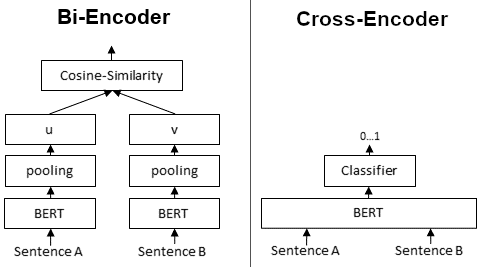

<br>

In [ ]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [ ]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [ ]:
scores

array([  3.8467617, -11.252879 ], dtype=float32)

In [ ]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [ ]:
cross_rerank_scores

array([ 0.10920248, -4.262066  , -3.6607146 , -2.1081762 , -2.562697  ,
       -1.2439425 , -3.4796028 , -5.749222  , -4.8183913 , -4.335735  ],
      dtype=float32)

In [ ]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [ ]:
results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 44', 'Policy_Name': 'Princi...",(4) Premium will be based on the Dependent's a...,0.301117,41,0.109202
1,"{'Page_No.': 'Page 59', 'Policy_Name': 'Princi...",Section C - Dependent Life Insurance Article 1...,0.309204,56,-4.262066
2,"{'Page_No.': 'Page 45', 'Policy_Name': 'Princi...",(1) If termination is as described in b. (1) a...,0.322103,42,-3.660715
3,"{'Page_No.': 'Page 22', 'Policy_Name': 'Princi...",The number of Members insured for Dependent Li...,0.324909,19,-2.108176
4,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",b . on any date the definition of Member or De...,0.330537,18,-2.562697
5,"{'Page_No.': 'Page 36', 'Policy_Name': 'Princi...",A Member's insurance under this Group Policy f...,0.331944,33,-1.243942
6,"{'Page_No.': 'Page 34', 'Policy_Name': 'Princi...",provided The Principal has been notified of th...,0.334379,31,-3.479603
7,"{'Page_No.': 'Page 60', 'Policy_Name': 'Princi...",I f a Dependent who was insured dies during th...,0.336051,57,-5.749222
8,"{'Page_No.': 'Page 7', 'Policy_Name': 'Princip...",Section A – Eligibility Member Life Insurance ...,0.336975,4,-4.818391
9,"{'Page_No.': 'Page 43', 'Policy_Name': 'Princi...",Any individual policy issued will then be in f...,0.338531,40,-4.335735


In [ ]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 44', 'Policy_Name': 'Princi...",(4) Premium will be based on the Dependent's a...,0.301117,41,0.109202
1,"{'Page_No.': 'Page 59', 'Policy_Name': 'Princi...",Section C - Dependent Life Insurance Article 1...,0.309204,56,-4.262066
2,"{'Page_No.': 'Page 45', 'Policy_Name': 'Princi...",(1) If termination is as described in b. (1) a...,0.322103,42,-3.660715


In [ ]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 44', 'Policy_Name': 'Princi...",(4) Premium will be based on the Dependent's a...,0.301117,41,0.109202
5,"{'Page_No.': 'Page 36', 'Policy_Name': 'Princi...",A Member's insurance under this Group Policy f...,0.331944,33,-1.243942
3,"{'Page_No.': 'Page 22', 'Policy_Name': 'Princi...",The number of Members insured for Dependent Li...,0.324909,19,-2.108176


In [ ]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [ ]:
top_3_RAG

,Documents,Metadatas
0,(4) Premium will be based on the Dependent's a...,"{'Page_No.': 'Page 44', 'Policy_Name': 'Princi..."
5,A Member's insurance under this Group Policy f...,"{'Page_No.': 'Page 36', 'Policy_Name': 'Princi..."
3,The number of Members insured for Dependent Li...,"{'Page_No.': 'Page 22', 'Policy_Name': 'Princi..."


In [ ]:
top_3_RAG['Documents'].values[0]

"(4) Premium will be based on the Dependent's age and the standard rate of The Principal for the policy form to be issued. b. Purchase Qualification A Dependent will qualify for individual purchase if: (1) Dependent Life Insurance, or any portion of it, terminates because he or she ceases to be a Dependent as defined in PART I; or because the Member dies, ends Active Work, or ceases to be in a class eligible for such insurance; or (2) the Dependent spouse's Dependent Life Insurance terminates as described in PART III, Section C; or (3) the Dependent spouse's or Civil Union Partner's Dependent Life Insurance terminates because of divorce or separation or termination of a Civil Union partnership from the Member; or (4) after the Dependent has been continuously insured for Dependent Life Insurance for at least five years, such insurance terminates because the Group Policy terminates, or is amended to eliminate Dependent Life Insurance, or the Member's insurance class; or (5) the Dependent

## 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [ ]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a insurance expert in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a insurance expert in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [ ]:
# Generate the response

response = generate_response(query, top_3_RAG)

In [ ]:
# Print the response

print("\n".join(response))

Based on the provided documents, the details about dependent life insurance rights and premium range are as follows:

**Dependent Life Insurance Rights and Premium Range:**

- Premium for Dependent Life Insurance is based on the Dependent's age.

- The number of Members insured for Dependent Life Insurance under the policy is not specified in the available documents.

Unfortunately, the specific premium range values are not provided in the retrieved documents. To get a detailed breakdown of the premium range and rights associated with Dependent Life Insurance, we recommend referring to the "Principal Insurance Policy" document found on Page 44.

**Citations:**
- Policy Name: Principal Insurance Policy
- Page Number: Page 44


# <font color = 'green'> Section Wise Chunking Strategy & Sentence Transformer Model Implemented

In [26]:
from PyPDF2 import PdfReader
import re
import pandas as pd

def extract_sections_with_pages(pdf_path):
    reader = PdfReader(pdf_path)
    data = []

    # Define a regex pattern to identify sections
    section_pattern = r"(PART [IVX]+ - .*?|Section [A-Z] - .*?|Article \d+ - .*?)\n"

    for page_no, page in enumerate(reader.pages, start=1):
        text = page.extract_text()
        matches = list(re.finditer(section_pattern, text))

        # If no sections are identified on the page, store the entire page as one chunk
        if not matches:
            data.append({"page_no": page_no, "title": "No Title Found", "chunk_text": text.strip()})
            continue

        # Iterate over section matches
        for i, match in enumerate(matches):
            start = match.end()
            end = matches[i + 1].start() if i + 1 < len(matches) else len(text)
            title = match.group(1).strip()
            chunk_text = text[start:end].strip()

            data.append({"page_no": page_no, "title": title, "chunk_text": chunk_text})

    return pd.DataFrame(data)


#def main():
 #   pdf_path = "/content/drive/MyDrive/upgrad/RAG/HelpMate Policy/Principal-Sample-Life-Insurance-Policy.pdf"
  #  df = extract_sections_with_pages(pdf_path)

    # Display the DataFrame
  #  print(df.head(100))
  #  return df

#if __name__ == "__main__":
 #   df = main()

def main():
    pdf_path = "/content/drive/MyDrive/upgrad/RAG/HelpMate Policy/Principal-Sample-Life-Insurance-Policy.pdf" # Specify the PDF path
    df = extract_sections_with_pages(pdf_path)  #Call extract_sections_with_pages and assign returned df to section_chunk_df

    # Display the DataFrame
    print(df.head(100))
    return df

if __name__ == "__main__":
    section_chunk_df = main() #assign df from main to section_chunk_df
    print(section_chunk_df)


# Create a DataFrame
#data = {'Title': titles, 'Section Title': section_titles, 'Chunk Text': section_texts}
#section_chunk_df = pd.DataFrame(data)

# Display the DataFrame
#section_chunk_df = section_chunk_df[section_chunk_df['Chunk Text'] != '']  # Remove empty sections
#section_chunk_df = section_chunk_df.reset_index(drop=True)  # Reset index
#section_chunk_df


    page_no                                          title  \
0         1                                 No Title Found   
1         2                                 No Title Found   
2         3                                 No Title Found   
3         4                                 No Title Found   
4         5                                 No Title Found   
..      ...                                            ...   
95       33  PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS   
96       33            Section B - Effective Dates, Page 6   
97       34  PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS   
98       34            Section B - Effective Dates, Page 7   
99       35  PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS   

                                           chunk_text  
0   GROUP POLICY FOR:  \nRHODE ISLAND JOHN DOE  \n...  
1                  This page left blank intentionally  
2   GC 806 VAL   \n POLICY RIDER  \n \nGROUP INSUR...  
3                  This page le

In [ ]:
#section_chunk_df.head(100)
#insurance_pdfs_data = section_chunk_df.reset_index(drop=True)
section_chunk_df = section_chunk_df[section_chunk_df['chunk_text'] != '']  # Remove empty sections
insurance_pdfs_data = section_chunk_df.reset_index(drop=True)  # Reset index
insurance_pdfs_data

,page_no,title,chunk_text
0,1,No Title Found,GROUP POLICY FOR: \nRHODE ISLAND JOHN DOE \n...
1,2,No Title Found,This page left blank intentionally
2,3,No Title Found,GC 806 VAL \n POLICY RIDER \n \nGROUP INSUR...
3,4,No Title Found,This page left blank intentionally
4,5,No Title Found,This policy has been updated effective January...
...,...,...,...
163,62,Article 6 - Autopsy,"If payment for loss of life is claimed, The Pr..."
164,62,Article 7 - Legal Action,Legal action to recover benefits under this Gr...
165,62,Article 8 - Time Limits,Any time limits in this section will be adjust...
166,63,No Title Found,This page left blank intentionally


In [ ]:
insurance_pdfs_data.chunk_text[19]

"(2) has been placed with the Member or spouse insured under this Group Policy by an \nauthorized state placement agency or by order of a court; and  \n(3) required documentation has been provided and the child is approved in Writing by \nThe Principal as a Dependent Child.  \n \nc. A Member's adopted child, if that child meets the requirements in a. above and the Member:  \n \n(1) is a party in a law suit in which the Member is seeking the adoption of the child; or  \n(2) has custody of the child under a court order that grants custody of the child to the \nMember.  \n \nAn adopted child will be considered a Dependent Child on the earlier of:  the date the \npetition for adoption is filed; or the date of entry of an order granting the adoptive parent custody of the child for the purpose of adoption.  \nd. A Civil Union Partner's child who otherwise qualifies above or if the Member or Civil \nUnion Pa rtner has been appointed the child's guardian under a valid court order.  \n \nDevelo

In [ ]:
insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['chunk_text'].apply(lambda x: len(x.split(' ')))

In [ ]:
insurance_pdfs_data['Text_Length']

,Text_Length
0,44
1,5
2,313
3,5
4,214
...,...
163,23
164,54
165,13
166,5


In [ ]:
# Install the sentence transformers library

!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer, util

In [ ]:
# Load pre-trained Sentence Transformer model

model_name = "all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Function to generate embeddings for text
def generate_embeddings(texts):
    embeddings = embedder.encode(texts, convert_to_tensor=True)
    return embeddings

In [ ]:
def generate_embeddings_on_df(df):
  df['Embeddings'] = df['chunk_text'].apply(lambda x: generate_embeddings([x])[0])

In [ ]:
generate_embeddings_on_df(insurance_pdfs_data)

In [ ]:
insurance_pdfs_data

,page_no,title,chunk_text,Text_Length,Embeddings
0,1,No Title Found,GROUP POLICY FOR: \nRHODE ISLAND JOHN DOE \n...,44,"[tensor(-0.0089), tensor(0.0380), tensor(0.054..."
1,2,No Title Found,This page left blank intentionally,5,"[tensor(0.0291), tensor(0.0606), tensor(0.0464..."
2,3,No Title Found,GC 806 VAL \n POLICY RIDER \n \nGROUP INSUR...,313,"[tensor(-0.1248), tensor(-0.0133), tensor(0.00..."
3,4,No Title Found,This page left blank intentionally,5,"[tensor(0.0291), tensor(0.0606), tensor(0.0464..."
4,5,No Title Found,This policy has been updated effective January...,214,"[tensor(-0.0807), tensor(0.0479), tensor(0.073..."
...,...,...,...,...,...
163,62,Article 6 - Autopsy,"If payment for loss of life is claimed, The Pr...",23,"[tensor(-0.0569), tensor(0.1389), tensor(0.018..."
164,62,Article 7 - Legal Action,Legal action to recover benefits under this Gr...,54,"[tensor(-0.0740), tensor(0.0751), tensor(0.037..."
165,62,Article 8 - Time Limits,Any time limits in this section will be adjust...,13,"[tensor(-0.0394), tensor(0.0296), tensor(0.034..."
166,63,No Title Found,This page left blank intentionally,5,"[tensor(0.0291), tensor(0.0606), tensor(0.0464..."


In [ ]:
output_path = '/content/drive/MyDrive/upgrad/RAG/HelpMate Policy/'

insurance_pdfs_data.to_csv(output_path+"section_chunk_embeddings.csv", index=False)

In [ ]:
# Read user input query
user_query1 = input()
user_query2 = input()
user_query3 = input()

What are dependent life insurance accidental premium charges?
What are individual purchase rights for member ?
What are claim procedures for Member Life insurance?


In [ ]:
# Define the function for calculating cosine similarity

def calculate_similarity(embedding1, embedding2):
    cosine_score = util.pytorch_cos_sim(embedding1, embedding2)
    # Convert the result to a Python float
    similarity = cosine_score.item()

    return similarity

In [ ]:
# Function to perform semantic search and return ranked chunks
def semantic_search(user_query, df, embedder):

    # Calculate the query embedding
    query_embedding = embedder.encode(user_query, convert_to_tensor=True)

    # Calculate similarity scores between the query embedding and all chunk embeddings
    df['Similarity'] = df['Embeddings'].apply(lambda x: calculate_similarity(query_embedding, x))

    # Sort the DataFrame by similarity scores in descending order
    df = df.sort_values(by='Similarity', ascending=False).reset_index(drop=True)

    # Return only the top 3 values from the dataframe, and drop the embeddings column for a cleaner view of the final results
    df = df.head(3)
    #df.drop('Embeddings', axis = 1, inplace=True)

    return df

In [ ]:
# Perform semantic search on each DataFrame
chunk_results_1 = semantic_search(user_query1, insurance_pdfs_data, embedder)
chunk_results_2 = semantic_search(user_query2, insurance_pdfs_data, embedder)
chunk_results_3 = semantic_search(user_query3, insurance_pdfs_data, embedder)

In [ ]:
chunk_results_1

,page_no,title,chunk_text,Text_Length,Embeddings,Similarity
0,7,Section B - Effective Dates,Member Life Insurance Article 1 \n \n Member...,27,"[tensor(-0.0561), tensor(0.0696), tensor(0.074...",0.652152
1,7,Section C - Individual Terminations,Member Life Insurance Article 1 \n \n Member...,47,"[tensor(-0.0395), tensor(0.0537), tensor(0.090...",0.641681
2,20,Article 2 - Premium Rates,The premium rate(s) for each Member insured fo...,97,"[tensor(0.0034), tensor(0.0401), tensor(0.0166...",0.626757


In [ ]:
chunk_results_2

,page_no,title,chunk_text,Text_Length,Embeddings,Similarity
0,6,PART II - POLICY ADMINISTRATION,Section A – Contract \n \n \n Entire Contract...,138,"[tensor(-0.0305), tensor(0.0560), tensor(0.019...",0.514770
1,6,Section D - Policy Renewal,Renewal Article 1 \n \nPART III - INDIVIDUA...,14,"[tensor(-0.0681), tensor(0.0121), tensor(0.068...",0.514372
2,6,Section C - Policy Termination,Failure to Pay Premium Article 1 \n Terminat...,36,"[tensor(-0.0179), tensor(0.0863), tensor(0.068...",0.499530


In [ ]:
chunk_results_3 #what are claim procedures for member life insurance

,page_no,title,chunk_text,Text_Length,Embeddings,Similarity
0,7,Section C - Individual Terminations,Member Life Insurance Article 1 \n \n Member...,47,"[tensor(-0.0395), tensor(0.0537), tensor(0.090...",0.635650
1,42,Article 1 - Member Life Insurance,a. Individual Policy \n \nIf a Member qualifi...,363,"[tensor(-0.0433), tensor(0.0695), tensor(-0.00...",0.632383
2,7,Section F - Individual Purchase Rights,Member Life Insurance Article 1 \n Dependent...,21,"[tensor(-0.0417), tensor(0.0947), tensor(0.100...",0.616111


In [ ]:
pip install plotly umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.1 MB/s eta 0:00:00


In [ ]:
import plotly.express as px
import umap

In [ ]:
import numpy as np

In [ ]:
# Combine all results into a single DataFrame for visualization
all_results = pd.concat([chunk_results_1, chunk_results_2, chunk_results_3], ignore_index=True)

# Keep a copy of 'all_results' with Embeddings for later use
all_results_with_embeddings = all_results.copy()  #This line added

# Assuming 'Embeddings' is the column containing embeddings as PyTorch tensors
embeddings = all_results_with_embeddings['Embeddings'].tolist()

# Convert PyTorch tensors to NumPy arrays
embeddings = [embedding.cpu().numpy() if hasattr(embedding, 'cpu') else embedding.numpy() for embedding in embeddings]

# Convert the list of embeddings into a 2D NumPy array
X = np.array(embeddings)

# Reduce dimensionality using UMAP
umap_model = umap.UMAP(n_components=2)
umap_embeddings = umap_model.fit_transform(X)

# Add UMAP embeddings as new columns in your dataframe
all_results['umap_x'] = umap_embeddings[:, 0]
all_results['umap_y'] = umap_embeddings[:, 1]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [ ]:
all_results

,page_no,title,chunk_text,Text_Length,Embeddings,Similarity,umap_x,umap_y
0,7,Section B - Effective Dates,Member Life Insurance Article 1 \n \n Member...,27,"[tensor(-0.0561), tensor(0.0696), tensor(0.074...",0.652152,12.881340,0.811887
1,7,Section C - Individual Terminations,Member Life Insurance Article 1 \n \n Member...,47,"[tensor(-0.0395), tensor(0.0537), tensor(0.090...",0.641681,13.651028,0.390730
2,20,Article 2 - Premium Rates,The premium rate(s) for each Member insured fo...,97,"[tensor(0.0034), tensor(0.0401), tensor(0.0166...",0.626757,12.980276,0.094535
3,6,PART II - POLICY ADMINISTRATION,Section A – Contract \n \n \n Entire Contract...,138,"[tensor(-0.0305), tensor(0.0560), tensor(0.019...",0.514770,12.382448,-1.347548
4,6,Section D - Policy Renewal,Renewal Article 1 \n \nPART III - INDIVIDUA...,14,"[tensor(-0.0681), tensor(0.0121), tensor(0.068...",0.514372,13.160657,-1.691976
5,6,Section C - Policy Termination,Failure to Pay Premium Article 1 \n Terminat...,36,"[tensor(-0.0179), tensor(0.0863), tensor(0.068...",0.499530,12.497963,-2.131318
6,7,Section C - Individual Terminations,Member Life Insurance Article 1 \n \n Member...,47,"[tensor(-0.0395), tensor(0.0537), tensor(0.090...",0.635650,12.098516,0.351183
7,42,Article 1 - Member Life Insurance,a. Individual Policy \n \nIf a Member qualifi...,363,"[tensor(-0.0433), tensor(0.0695), tensor(-0.00...",0.632383,12.514848,-0.543111
8,7,Section F - Individual Purchase Rights,Member Life Insurance Article 1 \n Dependent...,21,"[tensor(-0.0417), tensor(0.0947), tensor(0.100...",0.616111,13.544930,-0.685364


In [ ]:
print(all_results['Embeddings'].apply(lambda x: len(x)).unique())

[384]


In [ ]:
# Visualize the UMAP embeddings using Plotly
fig = px.scatter(all_results, x='umap_x', y='umap_y', hover_data=['title', 'chunk_text'])
fig.update_traces(marker=dict(size=3))  # Adjust marker size as needed
fig.show()

#### <font color = 'red'> USER QUERY 1
What are dependent life insurance accidental premium charges?

In [ ]:
# Compute the user query embedding (replace this with your actual query)
user_query_embedding = embedder.encode(user_query1, convert_to_tensor=True)

# Assuming user_query_embedding is a NumPy array of shape (1, 384)
# Reduce dimensionality of the user query embedding using the same UMAP model
user_query_umap = umap_model.transform(user_query_embedding.reshape(1, -1))

# Add the user query embedding to the DataFrame
user_query_df = pd.DataFrame({
    'umap_x': user_query_umap[:, 0],
    'umap_y': user_query_umap[:, 1],
    'title': 'User Query',
    'chunk_text': 'User Query'
})

# Concatenate the user query DataFrame with the original results
all_results = pd.concat([all_results, user_query_df], ignore_index=True)

# Specify colors based on a condition
all_results['color'] = np.where(all_results['title'] == 'User Query', 'User Query Color', 'Other Data Color')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [ ]:
# Visualize the UMAP embeddings with the user query using Plotly
fig = px.scatter(all_results, x='umap_x', y='umap_y', hover_data=['title', 'chunk_text'],
                 color='color', color_discrete_map={'User Query Color': 'red', 'Other Data Color': 'blue'})
fig.update_traces(marker=dict(size=3))  # Adjust marker size as needed
fig.show()

#### <font color = 'red'> USER QUERY 2
What are individual purchase rights for member ?

In [ ]:
 #Compute the user query embedding (replace this with your actual query)
user_query_embedding = embedder.encode(user_query2, convert_to_tensor=True)

# Assuming user_query_embedding is a NumPy array of shape (1, 384)
# Reduce dimensionality of the user query embedding using the same UMAP model
user_query_umap = umap_model.transform(user_query_embedding.reshape(1, -1))

# Add the user query embedding to the DataFrame
user_query_df = pd.DataFrame({
    'umap_x': user_query_umap[:, 0],
    'umap_y': user_query_umap[:, 1],
    'title': 'User Query',
    'chunk_text': 'User Query'
})

# Concatenate the user query DataFrame with the original results
all_results = pd.concat([all_results, user_query_df], ignore_index=True)

# Specify colors based on a condition
all_results['color'] = np.where(all_results['title'] == 'User Query', 'User Query Color', 'Other Data Color')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [ ]:
# Visualize the UMAP embeddings with the user query using Plotly
fig = px.scatter(all_results, x='umap_x', y='umap_y', hover_data=['title', 'chunk_text'],
                 color='color', color_discrete_map={'User Query Color': 'red', 'Other Data Color': 'blue'})
fig.update_traces(marker=dict(size=3))  # Adjust marker size as needed
fig.show()

#### <font color = 'red'> USER QUERY 3
what are claim procedures for member life insurance


In [ ]:
#Compute the user query embedding (replace this with your actual query)
user_query_embedding = embedder.encode(user_query3, convert_to_tensor=True)

# Assuming user_query_embedding is a NumPy array of shape (1, 384)
# Reduce dimensionality of the user query embedding using the same UMAP model
user_query_umap = umap_model.transform(user_query_embedding.reshape(1, -1))

# Add the user query embedding to the DataFrame
user_query_df = pd.DataFrame({
    'umap_x': user_query_umap[:, 0],
    'umap_y': user_query_umap[:, 1],
    'title': 'User Query',
    'chunk_text': 'User Query'
})

# Concatenate the user query DataFrame with the original results
all_results = pd.concat([all_results, user_query_df], ignore_index=True)

# Specify colors based on a condition
all_results['color'] = np.where(all_results['title'] == 'User Query', 'User Query Color', 'Other Data Color')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [ ]:
# Visualize the UMAP embeddings with the user query using Plotly
fig = px.scatter(all_results, x='umap_x', y='umap_y', hover_data=['title', 'chunk_text'],
                 color='color', color_discrete_map={'User Query Color': 'red', 'Other Data Color': 'blue'})
fig.update_traces(marker=dict(size=3))  # Adjust marker size as needed
fig.show()